<a href="https://colab.research.google.com/github/EstherWhang/jpm_changepoint/blob/main/sp500_pretty_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining a list of equities tickers and the corresponding timeseries

In [ ]:
! pip install --quiet yfinance

     |████████████████████████████████| 6.3 MB 36.3 MB/s 


In [ ]:
!pip install ruptures

     |████████████████████████████████| 918 kB 30.0 MB/s 


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns
sns.set(rc={'figure.figsize':(8,7)})
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# this workaround let's us override pandas_datareader with yfinance, 
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()

In [ ]:
# Configure filepaths for data storage
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Functions used for finding Breakpoint


In [ ]:
def plot_close(df, company_name, start, end):
    df_range = df.loc[(df['Date'] >= start) & (df['Date'] < end)]
    df_range.plot(x='Date',y='Close')
    plt.title(company_name)
    plt.show()

In [ ]:
def bin_seg(signal, dates, model, sigma = 5, changepoint_num = 1):
    #model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    algo = rpt.Binseg(model=model).fit(signal)
    bkps = 0
    if changepoint_num != 0: #we know the number of changepoints
      bkps = algo.predict(n_bkps=changepoint_num)
    else: #means we don't know how many changepoints there are
      bkps = algo.predict(epsilon=3 * len(signal) * sigma ** 2)
    # show results
    print("Binary Seg Breaks: "+ str(dates[bkps[:-1]]))

    plt.plot(dates, signal)
    plt.scatter(dates[bkps[:-1]],signal[bkps[:-1]], marker = "D", c = "red")
    plt.xticks(ticks=bkps[:-1], labels=dates[bkps[:-1]], rotation = 30)
    #rpt.show.display(signal, bkps)
    plt.title("Binary Segmentation")

    return dates[bkps[:-1]]

In [ ]:
def bottom_up(signal, dates, model, sigma = 5,changepoint_num = 1):
  #model = "l2"  # "l1", "rbf", "linear", "normal", "ar",...
    algo = rpt.BottomUp(model=model).fit(signal)
    bkps = 0
    if changepoint_num != 0: #we know the number of changepoints
      bkps = algo.predict(n_bkps=changepoint_num)
    else: #means we don't know how many changepoints there are
      bkps = algo.predict(epsilon=3 * len(signal) * sigma ** 2)
  # show results
    print("Bottom Up Breaks: "+ str(dates[bkps[:-1]]))
    plt.plot(dates, signal)
    plt.scatter(dates[bkps[:-1]],signal[bkps[:-1]], marker = "D", c = "red")
    plt.xticks(ticks=bkps[:-1], labels=dates[bkps[:-1]], rotation=30)
    #rpt.show.display(signal, bkps)
    plt.title("Bottom-up segmentation")
    return dates[bkps[:-1]]

In [ ]:
def dyn_p(signal, dates, model, changepoint_num = 1): #number of changepoints are known
      # change point detection
    algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(signal)
    bkps = algo.predict(n_bkps=changepoint_num )
    print("Dynamic Programming: "+ str(dates[bkps[:-1]]))
# show results
    plt.plot(dates, signal)
    plt.scatter(dates[bkps[:-1]],signal[bkps[:-1]], marker = "D", c = "red")
    plt.xticks(ticks=bkps[:-1], labels=dates[bkps[:-1]],rotation=30)
    #rpt.show.display(signal, bkps)
    plt.title("Dynamic Programming")
    return dates[bkps[:-1]]

In [ ]:
#models : "l2" linear, "rbf" gaussian
#Linearly penalized segmentation
#https://github.com/deepcharles/ruptures/blob/master/docs/examples/kernel-cpd-performance-comparison.ipynb
def pelt(signal, dates, model, jump= 1, min_size=2,beta=10): 
  #alternative to dynamic, when you don't know number of changepoints
    model = "rbf"
    algo = rpt.Pelt(model=model, jump=jump, min_size=min_size).fit(signal)
    bkps = algo.predict(pen=beta)
    
    print("PELT: "+ str(dates[bkps[:-1]]))

    plt.plot(dates, signal)
    plt.scatter(dates[bkps[:-1]],signal[bkps[:-1]], marker = "D", c = "red")
    plt.xticks(ticks=bkps[:-1], labels=dates[bkps[:-1]],rotation=30)
    #rpt.show.display(signal, bkps)
    plt.title("Linearly penalized segmentation")
    return dates[bkps[:-1]]

In [ ]:
def window(signal, dates, model, sigma = 5, changepoint_num = 1):
    algo = rpt.Window(width=10, model=model).fit(signal)
    bkps = 0
    if changepoint_num != 0: #we know the number of changepoints
      bkps = algo.predict(n_bkps=changepoint_num)
    else: #means we don't know how many changepoints there are
      bkps = algo.predict(epsilon=3 * len(signal) * sigma ** 2)
    # show results
    print("Window Breaks: "+ str(dates[bkps[:-1]]))

    plt.plot(dates, signal)
    plt.scatter(dates[bkps[:-1]],signal[bkps[:-1]], marker = "D", c = "red")
    plt.xticks(ticks=bkps[:-1], labels=dates[bkps[:-1]],rotation=30)
    #rpt.show.display(signal, bkps)
    plt.title("Window-based change point detection")
    return dates[bkps[:-1]]

## Get list of companies in SP500

We will obtain and store the list of the constituents from Wikipedia.

In [ ]:
today = datetime.today().strftime('%Y-%m-%d')
print(today)

data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S&P_500_component_stocks')

table   = data[0]
print(table.columns)
symbols = list(table.Symbol.values)
symb_sectors = table.loc[:,['Symbol','GICS Sector']]
sectors = list((table.loc[:,'GICS Sector']).drop_duplicates())
print(sectors)
df = pd.DataFrame(symb_sectors, columns=['Symbol', 'GICS Sector'])
print(df.head())
print("{} symbols in total".format(len(df)))

2021-12-03
Index(['Symbol', 'Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded'],
      dtype='object')
['Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Discretionary', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Consumer Staples', 'Energy']
  Symbol             GICS Sector
0    MMM             Industrials
1    ABT             Health Care
2   ABBV             Health Care
3   ABMD             Health Care
4    ACN  Information Technology
505 symbols in total


In [ ]:
#sort stocks into sectors
df_grouped_sectors = df.groupby('GICS Sector')

print((df_grouped_sectors.get_group(sectors[0]))["Symbol"])

#i can get group 

0       MMM
14      ALK
18     ALLE
27      AAL
35      AME
       ... 
464     URI
469    VRSK
479     WAB
483      WM
499     XYL
Name: Symbol, Length: 74, dtype: object


## Download price timeseries

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

downloading data for the first 2 quarters of 2020 for certain sector (financial for this example)

In [ ]:
start_date = '2020-01-01'
end_date  = '2020-06-30'

symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.get_data_yahoo(symbol, start_date, end_date)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()
dates = np.array(df.index)


History for SWK


## Pre-process Financial Timeseries

> changed so it gets information by sector



In [ ]:
print(list(df_grouped_sectors.get_group('Financials')["Symbol"]))

['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG', 'AIZ', 'BAC', 'BRK.B', 'BLK', 'BK', 'BRO', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CMA', 'DFS', 'RE', 'FITB', 'FRC', 'BEN', 'GL', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JPM', 'KEY', 'LNC', 'L', 'MTB', 'MKTX', 'MMC', 'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PBCT', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'SIVB', 'SYF', 'TROW', 'TRV', 'TFC', 'USB', 'WRB', 'WFC', 'WLTW', 'ZION']


In [ ]:
def normalize(df, columns, valid_dates):
    #normalize
  scaler = MinMaxScaler()

  #all stocks
  scaler.fit(df)
  scaled = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled, columns=columns)
  scaled_df.insert(0, 'Date', valid_dates)
  scaled_df.set_index('Date', inplace=True)
  return scaled_df

In [ ]:
def clean_up_data(df_price, df_volume):
  df_price.dropna(how='all', inplace=True)
  df_volume.dropna(how='all', inplace=True)
  assert((df_price.index == df_volume.index).all())


  return df_price, df_volume, df_price.index

In [ ]:
def price_volume_by_sector(df_grouped_sectors, sector, dates): #FIX THE DATES
  sector_symbols = list(df_grouped_sectors.get_group(sector)["Symbol"])
    # initialize an empty DateTime Index
  index = dates #ERROR i made a mistake with the dates
  df_sector_price = pd.DataFrame(index=index, columns=sector_symbols)               # initialize empty dataframes
  df_sector_volume = pd.DataFrame(index=index, columns=sector_symbols)

  for symbol in sector_symbols:
    sector_symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    sector_symbol_df.index = pd.to_datetime(sector_symbol_df.index, format='%Y-%m-%d')
    df_sector_price[symbol] = sector_symbol_df['Adj Close']
    df_sector_volume[symbol] = sector_symbol_df['Volume']
  return df_sector_price, df_sector_volume

In [ ]:
# Aggregate all symbols into a price dataframe and volume dataframe
# edited so it gets data by sector
#example is financial sector

sector_symbols = list(df_grouped_sectors.get_group( 'Financials')["Symbol"])
df_sector_price, df_sector_volume = price_volume_by_sector(df_grouped_sectors, 'Financials',dates)

In [ ]:
df_sector_price, df_sector_volume, valid_dates = clean_up_data(df_sector_price, df_sector_volume)
df_sector_price_normed = normalize(df_sector_price, sector_symbols, valid_dates)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
df_sector_price_normed.to_csv(os.path.join(data_dir, "sector_prices.csv"))
df_sector_volume.to_csv(os.path.join(data_dir, "sector_volume.csv"))

In [ ]:
df_sector_price_normed

,AFL,ALL,AXP,AIG,AMP,AON,AJG,AIZ,BAC,BRK.B,BLK,BK,BRO,COF,CBOE,SCHW,CB,CINF,C,CFG,CME,CMA,DFS,RE,FITB,FRC,BEN,GL,GS,HIG,HBAN,ICE,IVZ,JPM,KEY,LNC,L,MTB,MKTX,MMC,MET,MCO,MS,MSCI,NDAQ,NTRS,PBCT,PNC,PFG,PGR,PRU,RJF,RF,SPGI,STT,SIVB,SYF,TROW,TRV,TFC,USB,WRB,WFC,WLTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.997501,0.754706,0.836987,0.923561,0.882188,0.683977,0.664038,0.835467,1.000000,NaN,0.738226,0.976478,0.467429,0.951031,0.838518,0.962370,0.867787,0.860475,0.985308,0.995274,0.739285,1.000000,0.990902,0.894329,1.000000,0.938477,0.936421,0.894359,0.864823,0.992243,1.000000,0.773262,0.924609,1.000000,1.000000,0.958627,0.894347,0.976621,0.408749,0.816390,0.954841,0.636384,0.814687,0.332687,0.711184,0.961328,1.000000,0.994470,0.958624,0.316096,0.960643,NaN,1.000000,0.599447,NaN,0.881840,0.991077,0.736711,0.935205,1.000000,1.000000,0.708108,1.000000,0.782345,1.000000
2020-01-03,0.984294,0.754899,0.818596,0.912278,0.860518,0.675077,0.659116,0.845669,0.957580,NaN,0.715924,0.949176,0.469799,0.926002,0.873272,0.902749,0.864379,0.868620,0.952252,0.962193,0.771605,0.975899,0.967412,0.887274,0.970026,0.931591,0.889192,0.870590,0.840772,0.983336,0.977601,0.833726,0.897803,0.969751,0.970849,0.918547,0.886933,0.955854,0.407919,0.812430,0.936689,0.631379,0.786229,0.289617,0.720636,0.913846,0.980395,0.975114,0.933491,0.315536,0.933128,NaN,0.966842,0.592915,NaN,0.853659,0.968983,0.728945,0.926916,0.984723,0.977205,0.710605,0.989186,0.783035,0.973742
2020-01-06,0.978940,0.761247,0.810652,0.913406,0.866166,0.681590,0.669945,0.847612,0.954714,NaN,0.717696,0.968918,0.468022,0.911700,0.851383,0.918876,0.882556,0.856251,0.946851,0.953922,0.781660,0.953124,0.942930,0.882234,0.957106,0.899385,0.907357,0.860215,0.861575,0.978739,0.947737,0.834632,0.907855,0.967953,0.945863,0.907514,0.861725,0.939239,0.383131,0.813129,0.931894,0.637635,0.780131,0.300181,0.719197,0.911053,0.969192,0.971092,0.936250,0.391104,0.937133,NaN,0.947154,0.607876,NaN,0.845862,0.968558,0.743530,0.929453,0.969447,0.950776,0.707830,0.978700,0.786483,0.951387
2020-01-07,0.961093,0.742586,0.801089,0.905226,0.845421,0.662379,0.644594,0.833038,0.941529,NaN,0.730970,0.990339,0.460913,0.896154,0.813556,0.932560,0.837965,0.826235,0.931944,0.944076,0.776872,0.942953,0.927876,0.863473,0.939535,0.886059,0.931880,0.858329,0.875093,0.963223,0.927827,0.826469,0.905342,0.929529,0.933370,0.921925,0.852828,0.915149,0.387989,0.805209,0.943539,0.630378,0.776743,0.303107,0.682419,0.923514,0.949587,0.955382,0.946977,0.358753,0.935392,NaN,0.923322,0.621501,NaN,0.854159,0.947313,0.753001,0.895449,0.961646,0.932606,0.672870,0.964282,0.780690,0.940387
2020-01-08,0.966804,0.748550,0.832426,0.922150,0.860723,0.671604,0.647794,0.841135,0.961593,NaN,0.730476,0.992859,0.478092,0.912633,0.790323,0.946732,0.823054,0.817335,0.944907,0.956285,0.790159,0.954230,0.942434,0.857038,0.943152,0.896498,0.919164,0.857385,0.895018,0.972417,0.942759,0.801377,0.910368,0.946861,0.949194,0.942190,0.853199,0.925117,0.342524,0.797523,0.962033,0.668917,0.798764,0.336831,0.670297,0.944355,0.963591,0.975868,0.954333,0.383593,0.945841,NaN,0.933684,0.649807,NaN,0.871182,0.958785,0.775731,0.919979,0.965546,0.928642,0.686188,0.969525,0.783862,0.958129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,0.409649,0.463372,0.456264,0.388386,0.691877,0.478725,0.734847,0.408415,0.397074,NaN,0.959216,0.489146,0.572972,0.433235,0.382297,0.375162,0.514580,0.241284,0.394124,0.435170,0.418006,0.326713,0.502907,0.412908,0.503730,0.735437,0.598607,0.318500,0.627824,0.392923,0.446388,0.817749,0.409404,0.325664,0.455044,0.500815,0.208142,0.256805,0.993379,0.692795,0.484938,0.940703,0.699108,0.902656,0.954298,0.423814,0.348812,0.358999,0.568070,0.786573,0.443754,NaN,0.503056,0.965995,NaN,0.6

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 9 Text major ticklabel objects>)

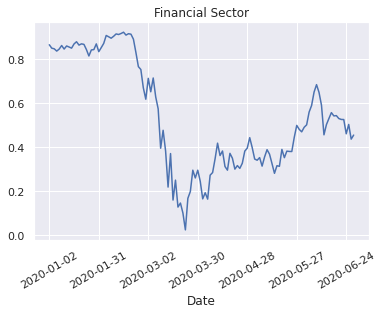

In [ ]:
df_sector_price_normed.mean(axis=1).plot()
plt.title("Financial Sector")
plt.xticks(rotation=30)

Looking at changepoint by the averages of each sector

In [ ]:
#to plot the mean of all sectors: 
index = dates
df_mean_price = pd.DataFrame(index=index, columns=sectors)               # initialize empty dataframes
df_mean_volume = pd.DataFrame(index=index, columns=sectors)
for sector in sectors:
  df_sector_price, df_sector_volume = price_volume_by_sector(df_grouped_sectors, sector, dates)
  df_mean_price[sector] = df_sector_price.mean(axis=1)
  df_mean_volume[sector] = df_sector_volume.mean(axis=1)


In [ ]:
df_mean_price, df_mean_volume, valid_dates = clean_up_data(df_mean_price, df_mean_volume)
print(df_mean_price.head())
df_mean_price_normed = normalize(df_mean_price, sectors, valid_dates)
print(df_mean_price_normed.head())

            Industrials  Health Care  ...  Consumer Staples     Energy
2020-01-02   136.406216   171.337934  ...         87.910953  55.068361
2020-01-03   136.559744   169.703509  ...         88.204447  54.974962
2020-01-06   136.485002   171.229477  ...         88.419473  55.579494
2020-01-07   136.523850   171.354470  ...         87.718593  55.920424
2020-01-08   136.909677   172.617488  ...         88.247953  54.744212

[5 rows x 11 columns]
            Industrials  Health Care  ...  Consumer Staples    Energy
Date                                  ...                            
2020-01-02     0.907505     0.734892  ...          0.809038  0.976645
2020-01-03     0.910144     0.708354  ...          0.822211  0.974085
2020-01-06     0.908859     0.733131  ...          0.831861  0.990655
2020-01-07     0.909527     0.735161  ...          0.800405  1.000000
2020-01-08     0.916158     0.755669  ...          0.824163  0.967761

[5 rows x 11 columns]


In [ ]:
df_mean_price_normed.to_csv(os.path.join(data_dir, "mean_prices.csv"))
df_mean_volume.to_csv(os.path.join(data_dir, "mean_volume.csv"))


Text(0.5, 1.0, 'Volume by Sector')

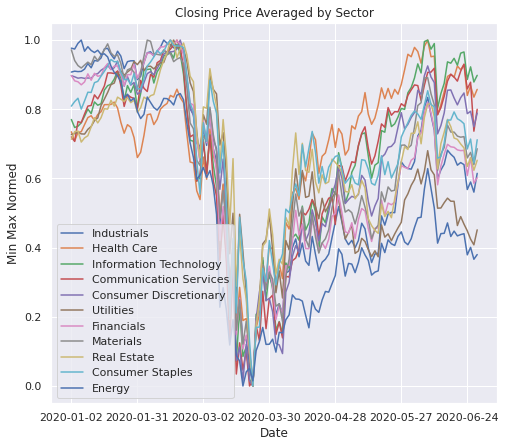

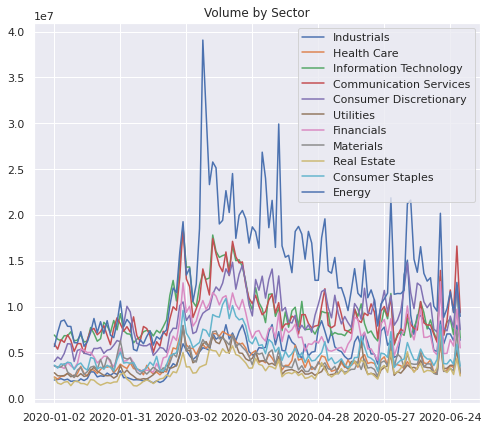

In [ ]:
df_mean_price_normed.plot()
plt.title("Closing Price Averaged by Sector")
plt.ylabel("Min Max Normed")
df_mean_volume.plot()
plt.title("Volume by Sector")


In [ ]:
df_mean_price_normed["Financials"].head()

Date
2020-01-02    0.897584
2020-01-03    0.882138
2020-01-06    0.879416
2020-01-07    0.870679
2020-01-08    0.879132
Name: Financials, dtype: float64

In [ ]:
import ruptures as rpt
%matplotlib inline

change points

In [ ]:
def breakpoints_by_sector(index, signal, sector, model, sigma = 5, changepoint_num=1):
  signal = np.array(signal)
  dates = np.array(index)
  print("-----------------------------------------------")
  print(sector)
  bkps_sector = []
  #known change point
  if changepoint_num > 0 :
    print("---------------Known Break Point---------------")
    plt.figure(figsize=(14,6))
    plt.subplot(2,2,1)
    binseg_bkps = bin_seg(signal, dates, model,changepoint_num = changepoint_num)
    plt.subplot(2,2,2)
    bottom_up_bkps = bottom_up(signal, dates, model,changepoint_num = changepoint_num)
    plt.subplot(2,2,3)
    dyn_p_bkps = dyn_p(signal, dates, model,changepoint_num = changepoint_num)
    plt.subplot(2,2,4)
    window__bkps = window(signal, dates, model,changepoint_num = changepoint_num)
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)
    plt.suptitle(sector)
    bkps_sector.append([binseg_bkps, binseg_bkps,dyn_p_bkps,window__bkps])
  else:

    print("-----------------------------------------------")
    print("--------------Unknown Break Point--------------")
  #note: since there is no artificial breakpoint, color change is the rupture's prediction
    plt.figure(figsize=(14, 6))
    plt.subplot(2,2,1)
    binseg_bkps=bin_seg(signal, dates, model,sigma = sigma, changepoint_num = 0)
    plt.subplot(2,2,2)
    bottom_up_bkps=bottom_up(signal, dates, model, sigma = sigma, changepoint_num = 0)
    plt.subplot(2,2,3)
    pelt_bkps = pelt(signal, dates, model) 
    plt.subplot(2,2,4)
    window__bkps = window(signal, dates, model,sigma = sigma,  changepoint_num = 0)
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)
    plt.suptitle(sector)
    bkps_sector.append([binseg_bkps, binseg_bkps,pelt_bkps,window__bkps])
  return bkps_sector

Financial Sector with Known number of break points: 1 break point

All models are able to detect the March 9, 2020 Crash as a major changepoint

-----------------------------------------------
Financials
---------------Known Break Point---------------
Binary Seg Breaks: ['2020-03-09']
Bottom Up Breaks: ['2020-03-09']
Dynamic Programming: ['2020-03-09']
Window Breaks: ['2020-03-09']


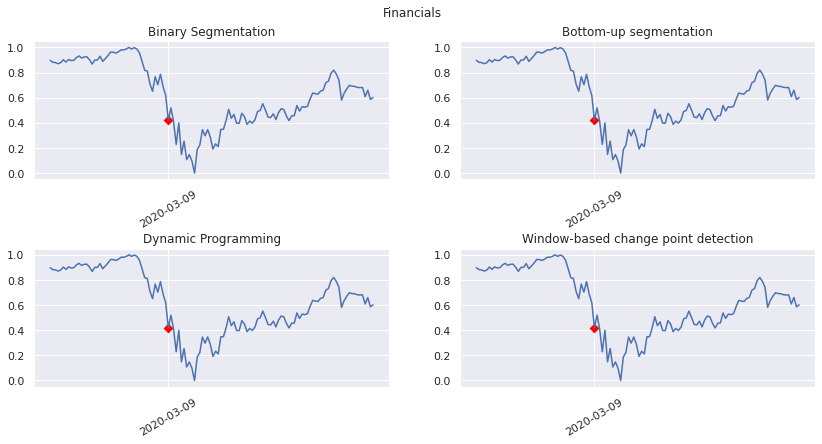

In [ ]:
model = "l2"

#pick one breakpoint, 11 sectors, that'll get 11 dates, create a slide with assumed 1 breakpoint and compare
#then talk about the best changepoint

#just known
sector = "Financials"
signal = df_mean_price_normed[sector]
bkps_sector = breakpoints_by_sector(index, signal, sector, model, changepoint_num=1) #play around for best results
#annotate and create narrative with wikipedia dates
detectors = ["Bin Seg", "Bottom-Up", "Dynamic Prog", "Window"]
bkps = np.squeeze(bkps_sector)

# creating df object with columns specified    


Financial Sector with Known number of break points: 2 break points

All models are able to detect the March 9, 2020 Crash as a major changepoint.
Depending on model, detects an additional changepoint in February 24th, which was the start of the COVID-19 drops, or detects the brief recovery that happened near the end of May.

-----------------------------------------------
Financials
---------------Known Break Point---------------
Binary Seg Breaks: ['2020-03-09' '2020-05-19']
Bottom Up Breaks: ['2020-03-09' '2020-05-27']
Dynamic Programming: ['2020-03-09' '2020-05-19']
Window Breaks: ['2020-02-24' '2020-03-09']


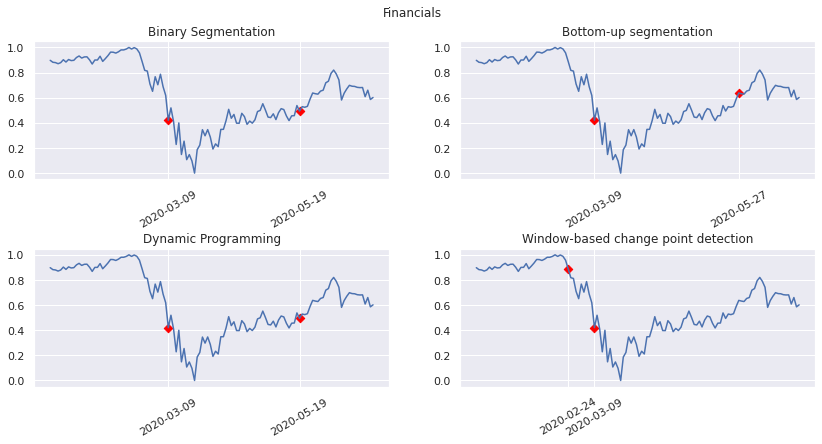

In [ ]:
model = "l2"

sector = "Financials"
signal = df_mean_price_normed[sector]
bkps_sector = breakpoints_by_sector(index, signal, sector, model, changepoint_num=2) #play around for best results
#annotate and create narrative with wikipedia dates
detectors = ["Bin Seg", "Bottom-Up", "Dynamic Prog", "Window"]
bkps = np.squeeze(bkps_sector)

# creating df object with columns specified    


-----------------------------------------------
Financials
---------------Known Break Point---------------
Binary Seg Breaks: ['2020-02-24' '2020-03-09' '2020-04-06' '2020-05-19']
Bottom Up Breaks: ['2020-02-24' '2020-03-09' '2020-04-06' '2020-05-27']
Dynamic Programming: ['2020-02-24' '2020-03-09' '2020-04-06' '2020-05-27']
Window Breaks: ['2020-02-24' '2020-03-09' '2020-04-06' '2020-06-03']


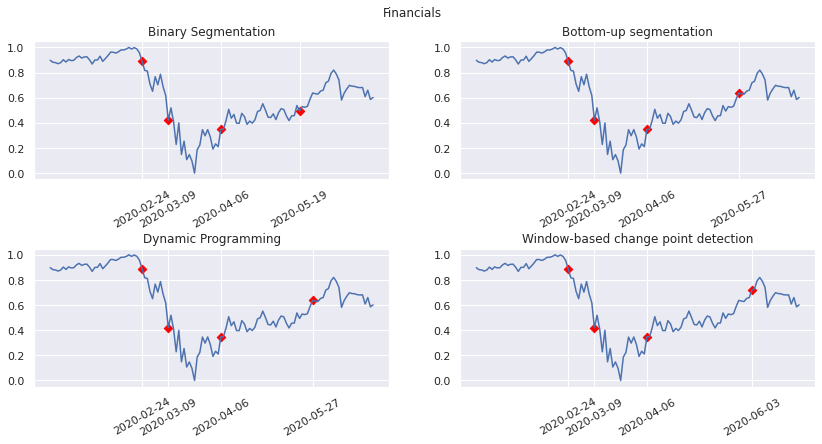

In [ ]:
model = "l2"

#larger number of breakpoints

#just known
sector = "Financials"
signal = df_mean_price_normed[sector]
bkps_sector = breakpoints_by_sector(index, signal, sector, model, changepoint_num=4) #play around for best results
#annotate and create narrative with wikipedia dates
detectors = ["Bin Seg", "Bottom-Up", "Dynamic Prog", "Window"]
bkps = np.squeeze(bkps_sector)

# creating df object with columns specified    


In [ ]:
breakpoints_finance_per_model= pd.DataFrame(np.transpose(bkps), columns =detectors) 
breakpoints_finance_per_model  #add the dates for the rupture plots

,Bin Seg,Bottom-Up,Dynamic Prog,Window
0,2020-02-24,2020-02-24,2020-02-24,2020-02-24
1,2020-03-09,2020-03-09,2020-03-09,2020-03-09
2,2020-04-06,2020-04-06,2020-04-06,2020-04-06
3,2020-05-19,2020-05-19,2020-05-27,2020-06-03


-----------------------------------------------
Industrials
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-02-24' '2020-03-09' '2020-04-06' '2020-05-19']
Bottom Up Breaks: ['2020-02-24' '2020-03-09' '2020-05-19']
PELT: ['2020-03-06' '2020-05-26']
Window Breaks: ['2020-02-24' '2020-03-16' '2020-04-06' '2020-04-28' '2020-06-03']
-----------------------------------------------
Health Care
-----------------------------------------------
--------------Unknown Break Point--------------
Binary Seg Breaks: ['2020-03-09' '2020-03-16' '2020-04-06' '2020-05-05']
Bottom Up Breaks: ['2020-02-24' '2020-03-16' '2020-04-14' '2020-05-05']
PELT: ['2020-02-25' '2020-05-07']
Window Breaks: ['2020-02-24' '2020-03-16' '2020-04-06' '2020-05-05' '2020-05-27'
 '2020-06-10']
-----------------------------------------------
Information Technology
-----------------------------------------------
--------------Unknown Break Point-------------

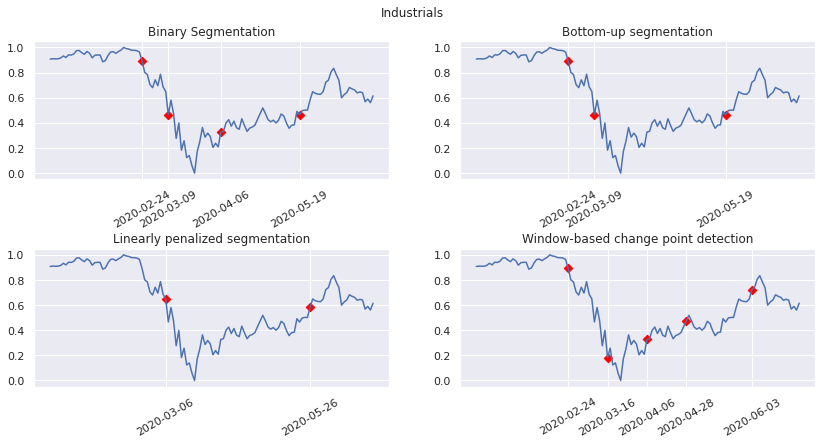

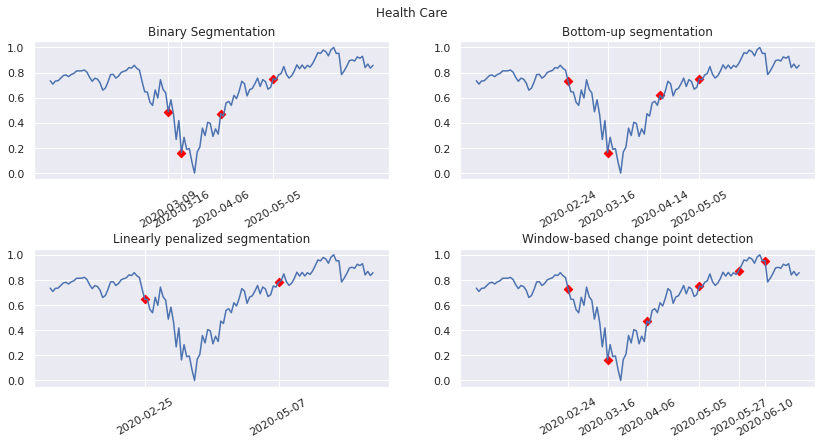

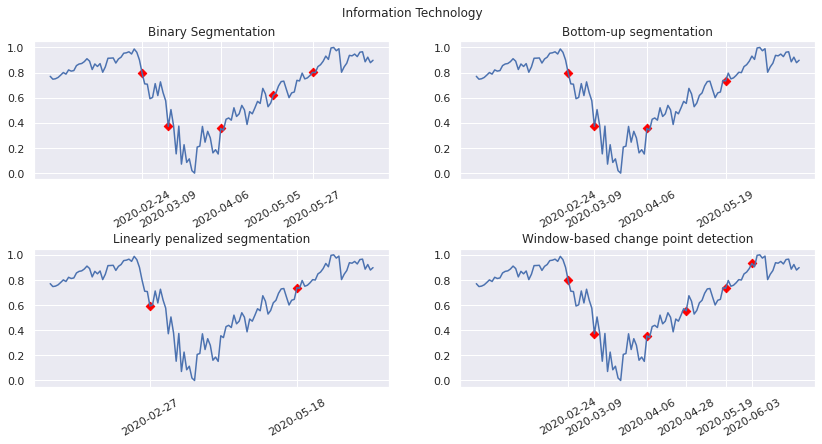

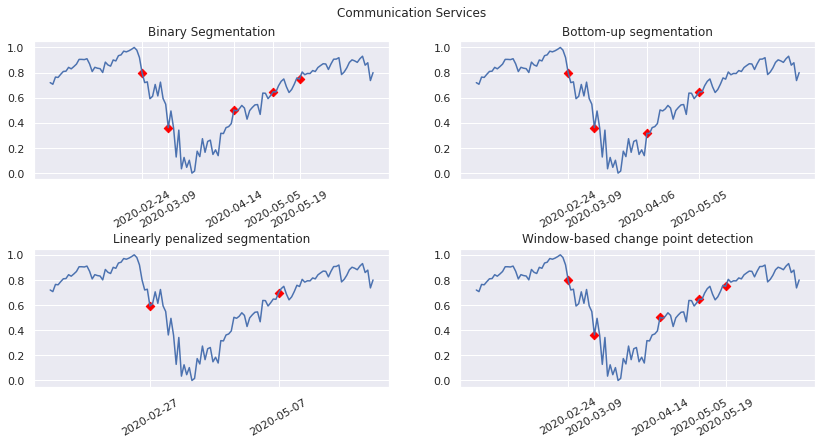

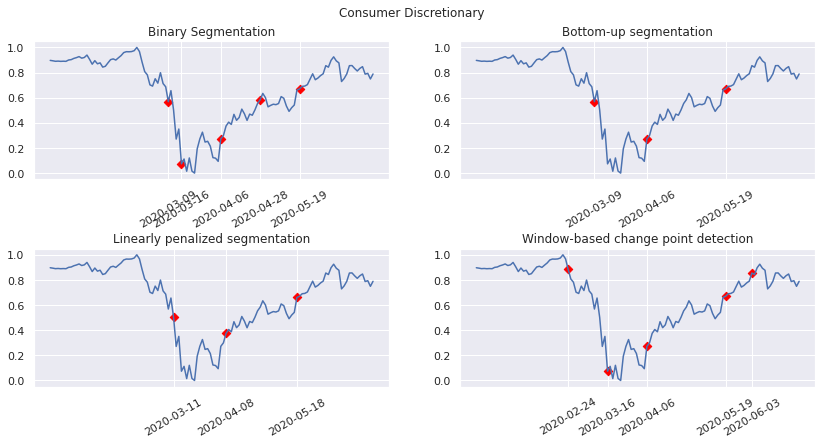

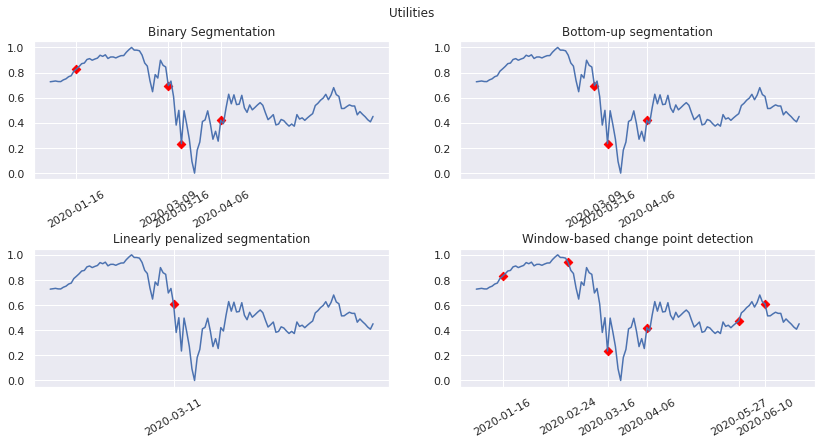

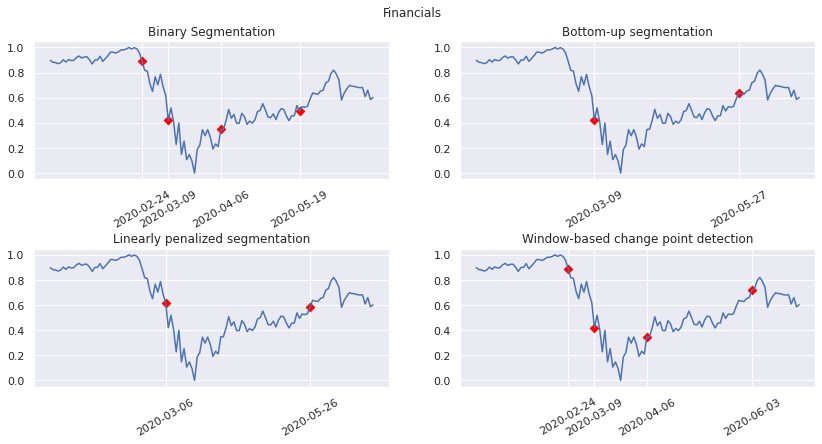

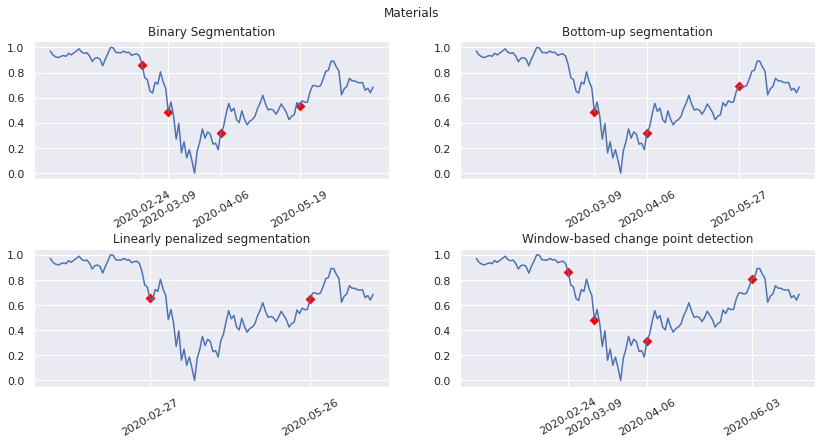

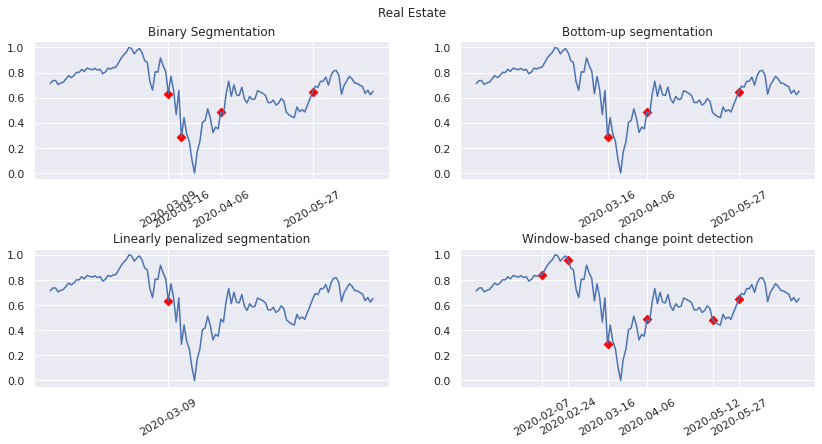

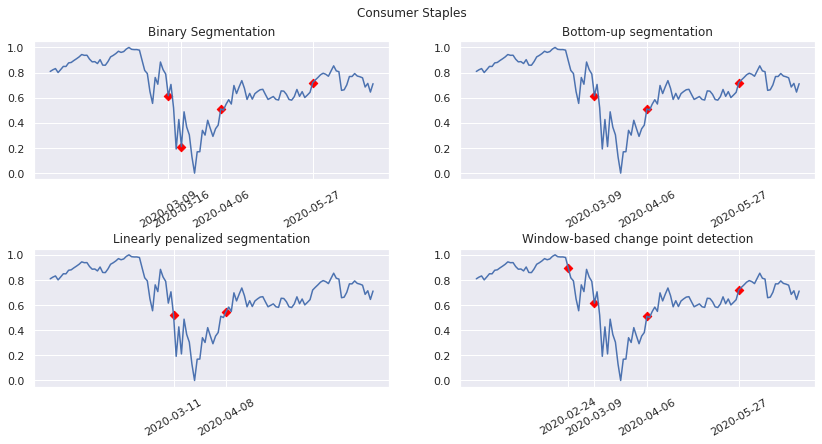

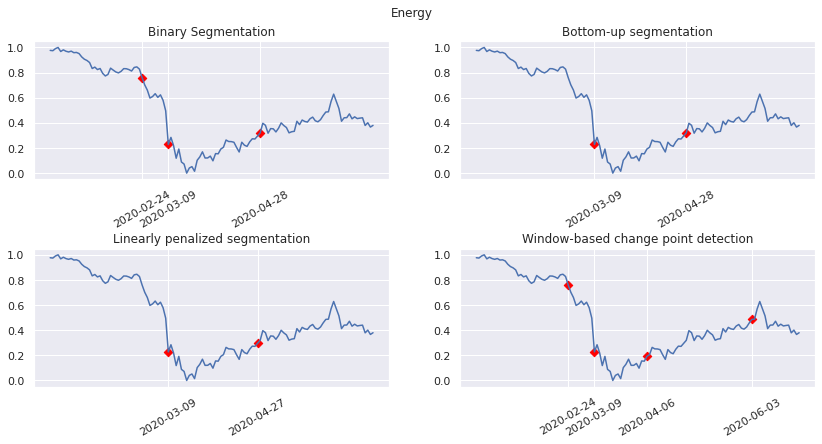

In [ ]:
model = "l2" #except for PELT due to l2 not giving 
#unknown number of breakpoints
#compare changepoint dates by sector
total_bkps = []
for sector in sectors:
  signal = df_mean_price_normed[sector]
  bkps_sector = breakpoints_by_sector(index, signal, sector, model,  sigma = 0.05, changepoint_num=0)